In [5]:
from google.colab import files
uploaded = files.upload()

Saving bank-additional-full.csv to bank-additional-full.csv


In [6]:
##import all libraries
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import scipy.stats as stats


#Single model classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost as xgb

#Ensemble classifications models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

#Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,confusion_matrix, classification_report, roc_auc_score,
f1_score, recall_score, precision_score, SCORERS)
import time

# Imbalance, Hyperparameter tunning and pipelines
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
!pip install category_encoders
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings;warnings.filterwarnings('ignore')

#!pip install pandas


In [7]:
## read the csv file and create data frame

df = pd.read_csv('bank-additional-full.csv',sep =';', quotechar ='"', quoting=3, engine='python')

#remove extra double quotes from column names
df.columns = df.columns.str.strip('""')

df = df.apply(lambda x: x.str.strip('""') if x.dtype == 'object' else x)

df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [8]:
df.info()

df['age'] = pd.to_numeric(df['age'], errors='coerce')

df.info()

## This indicates we have the following categorical variables:
#Job, marital, education, default, housing, loan, contact, month, pout come
# The following variables are integer
#age, balance, day, duration, campaign, pdays,previous
#target or o.p variable = 'deposit'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  object 
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [9]:
df.nunique()

# Initialize a dictionary to store non-unique values for each column
non_unique_values = {}

# Iterate through each column
for column in df.columns:
    non_unique = df[df.duplicated(column, keep=False)][column].unique()
    non_unique_values[column] = non_unique

# Print non-unique values for each column
for column, values in non_unique_values.items():
    print(f'Non-unique values in {column}: {values}')

Non-unique values in age: [56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 91 86 98
 84 92 89]
Non-unique values in job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
Non-unique values in marital: ['married' 'single' 'divorced' 'unknown']
Non-unique values in education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
Non-unique values in default: ['no' 'unknown' 'yes']
Non-unique values in housing: ['no' 'yes' 'unknown']
Non-unique values in loan: ['no' 'yes' 'unknown']
Non-unique values in contact: ['telephone' 'cellular']
Non-unique values in month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
Non-unique values in day_of_week: ['mon' 'tue' '

In [10]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [11]:
## Define my colour palette

# custom colors

my_colors = ["#c6b34e","#95354a", "#57b9a8","#b0ddff", "#426872","#215c97", "#02b6b4","#b05468","#cd9f62","#aaaaaa","#8fce00","#827861"]
# Create a seaborn palette object
my_palette = sns.color_palette(my_colors)
# Use the custom palette with a seaborn function
sns.set_palette(my_palette)
from matplotlib.colors import ListedColormap
colors = ['#ffffcd', '#ffeaa4', '#ffca2a','#c6b34e']
my_cmap = sns.color_palette(colors)
cmap = ListedColormap(colors)



In [12]:
# Display an overview of the dataset
#!pip install skimpy
#from skimpy import skim
#skim(df)

In [13]:
value_counts = df['y'].value_counts()
print(f'count of deposit being 0: {value_counts[0]}')
print(f'count of deposit being 1:{value_counts[1]}')

## This output indicates the dataset target values  are imbalanced

count of deposit being 0: 36548
count of deposit being 1:4640


In [14]:
## Separating the data as X & Y
X = df.drop(['y'], axis=1)
y = df['y']

#convert the y label to a data frame
y1 = y.to_frame()

In [19]:
df_obj_cols = X.select_dtypes(exclude='number').columns
print('obj_cols:',df_obj_cols)

##obj_cols doesn't have the y column va lue

df_obj_cols1 = df.select_dtypes(exclude='number').columns
print('obj_cols1:', df_obj_cols1)

#obj_cols1 has the y column too.

obj_cols: Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')
obj_cols1: Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')


In [16]:
df_num_cols = df.select_dtypes(include='number').columns
df_num_cols

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [20]:
df_numeric = df[df_num_cols]
## df_obj holds the dataset without the y column and all categorical variables present
df_obj =df[df_obj_cols]
## df_obj1 holds the dataset with the y column and all categorical variables present
df_obj1 = df[df_obj_cols1]

In [ ]:
df.isnull().sum()

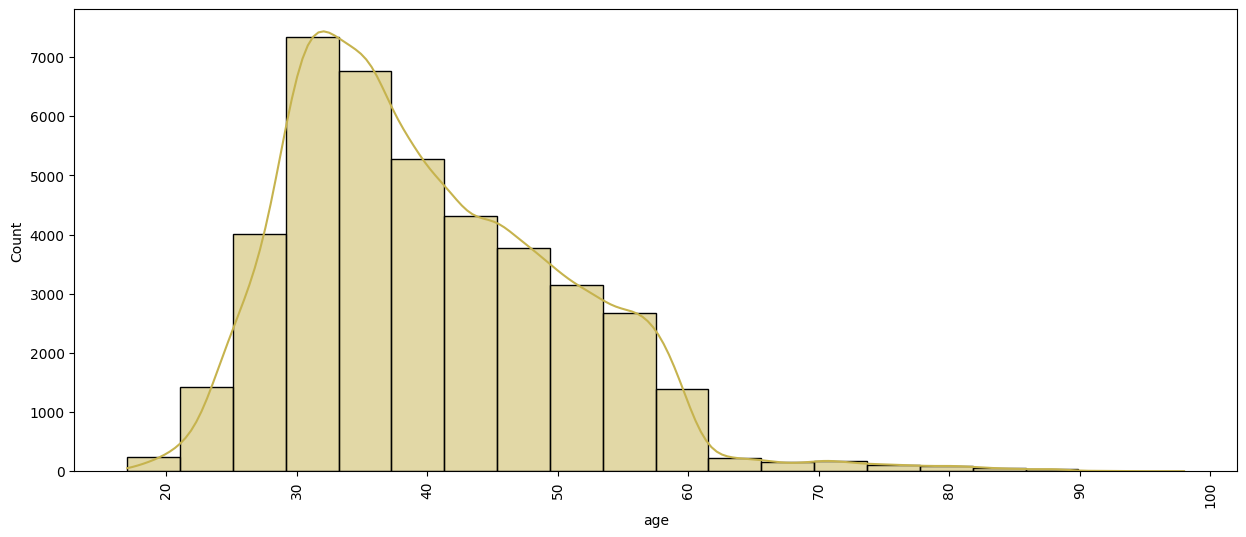

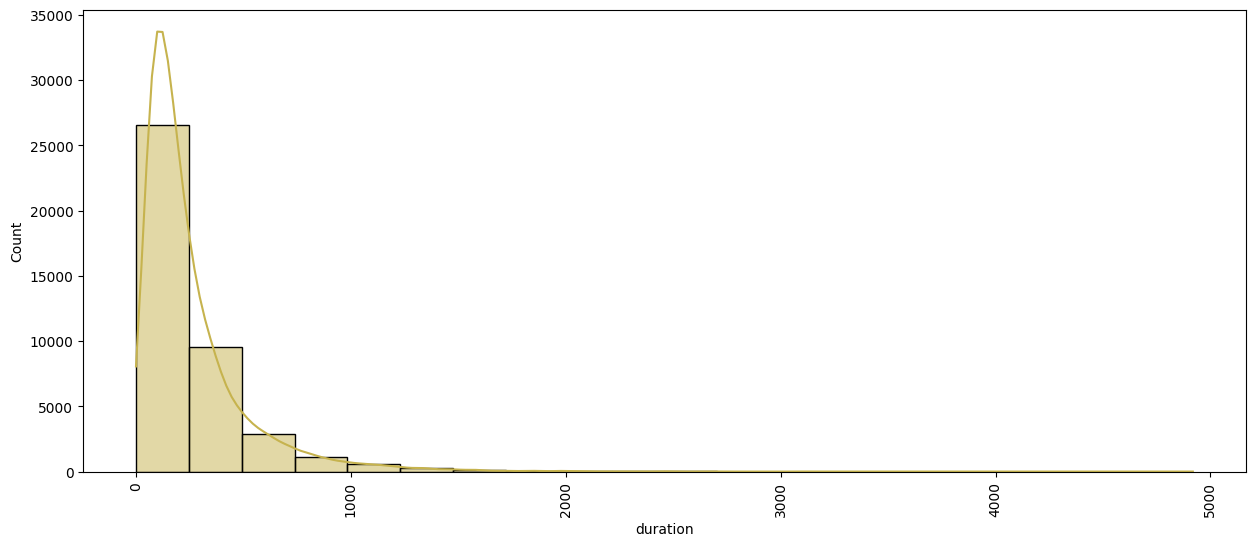

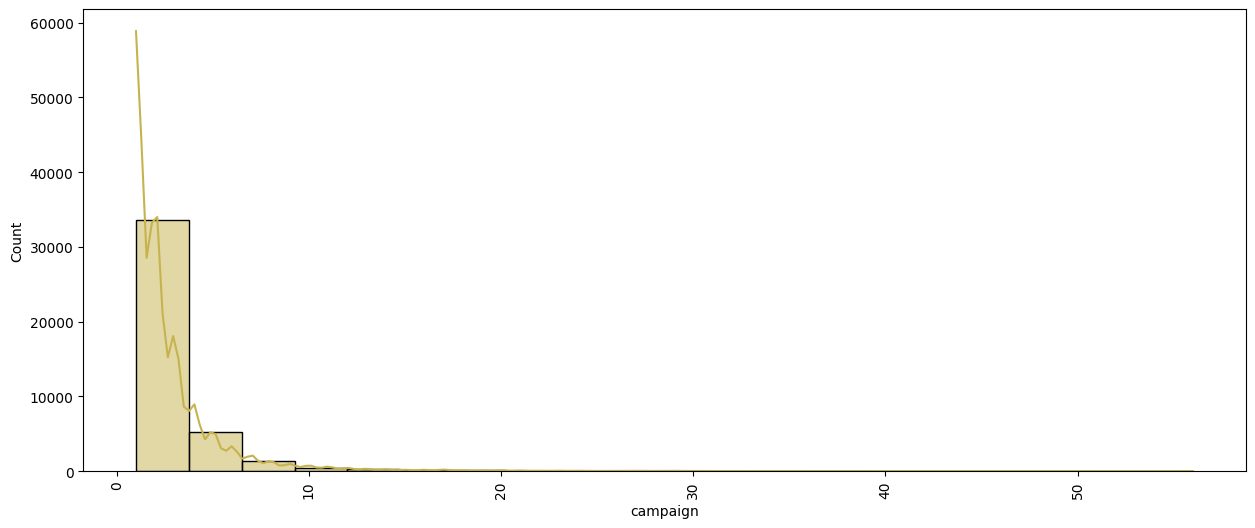

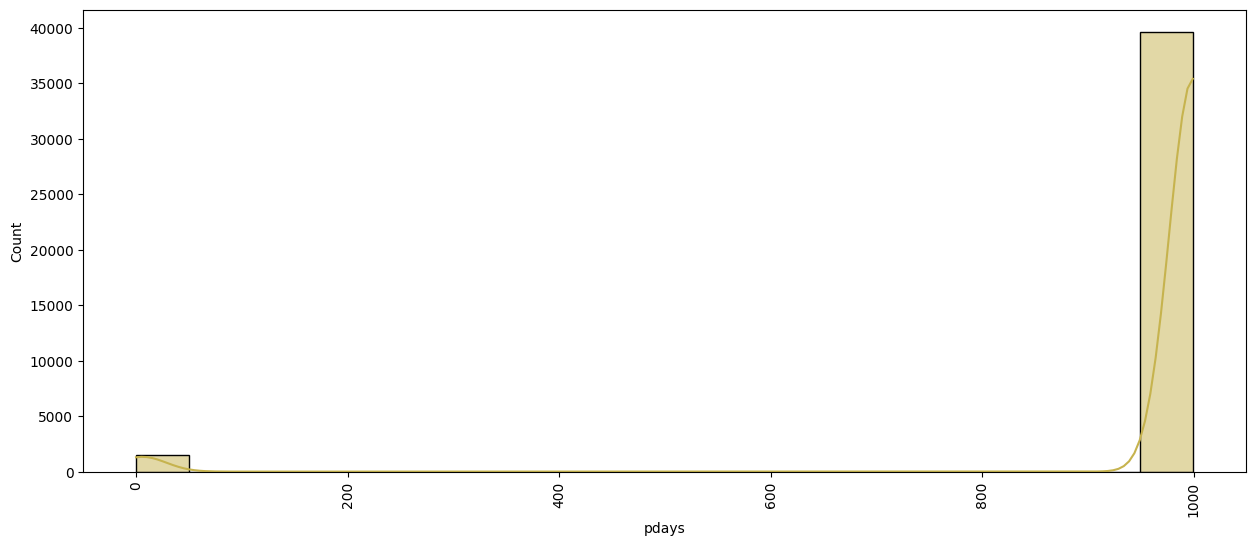

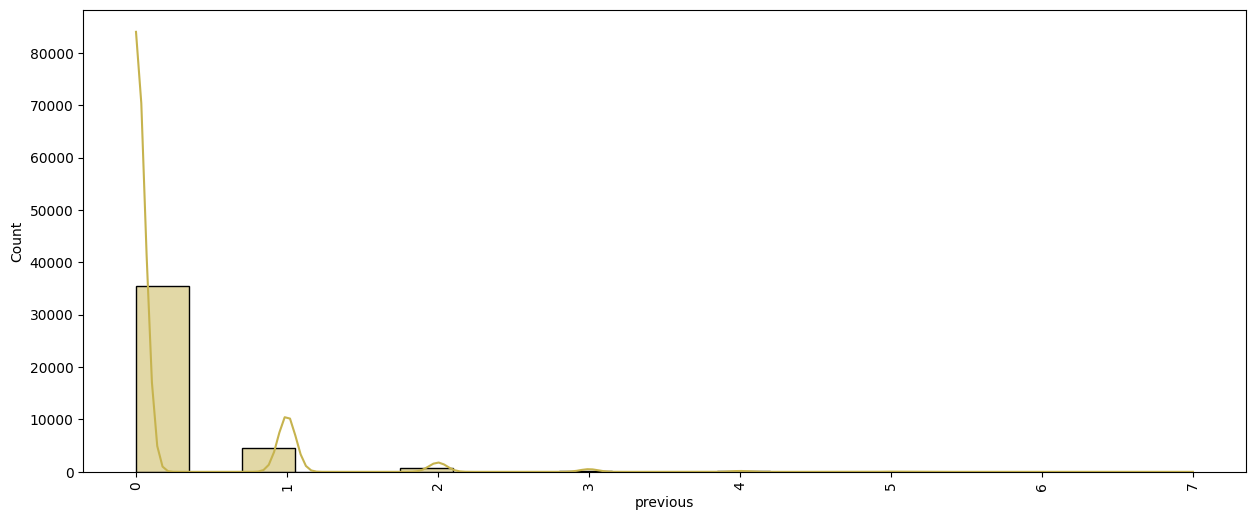

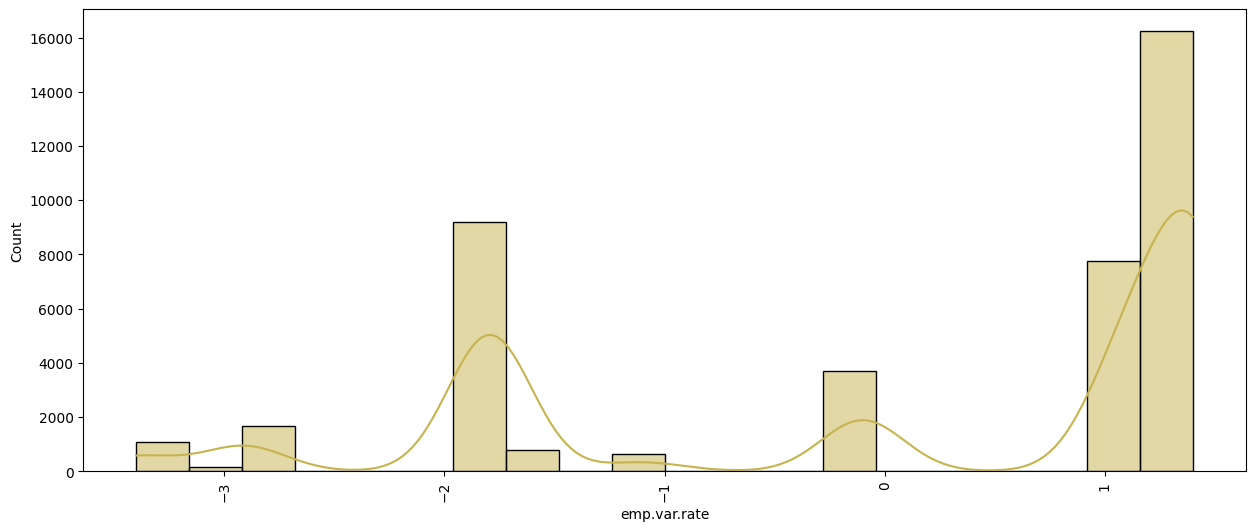

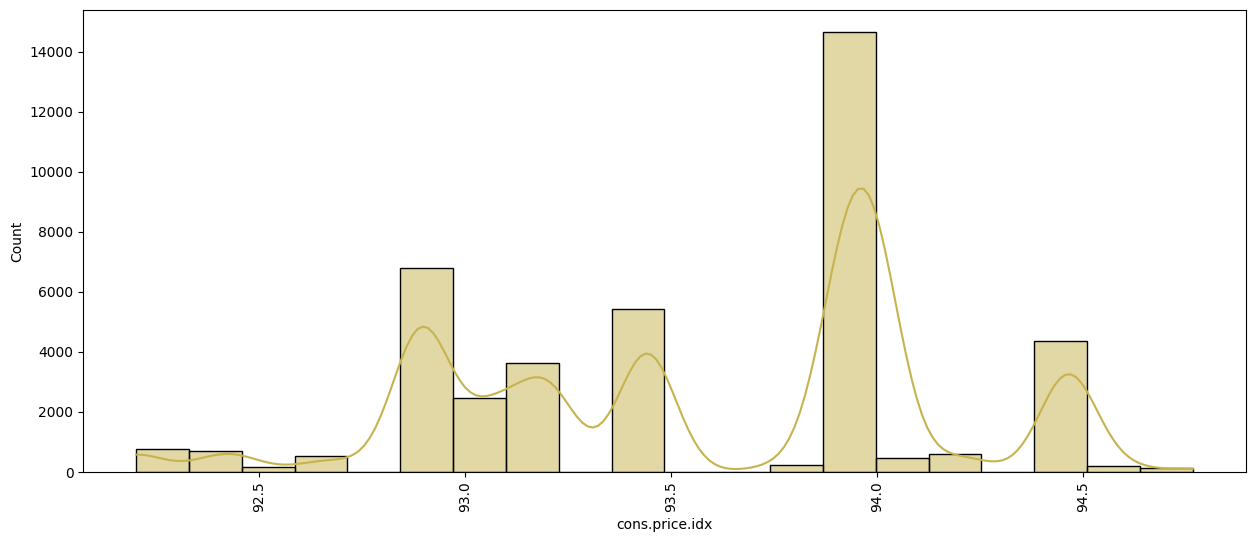

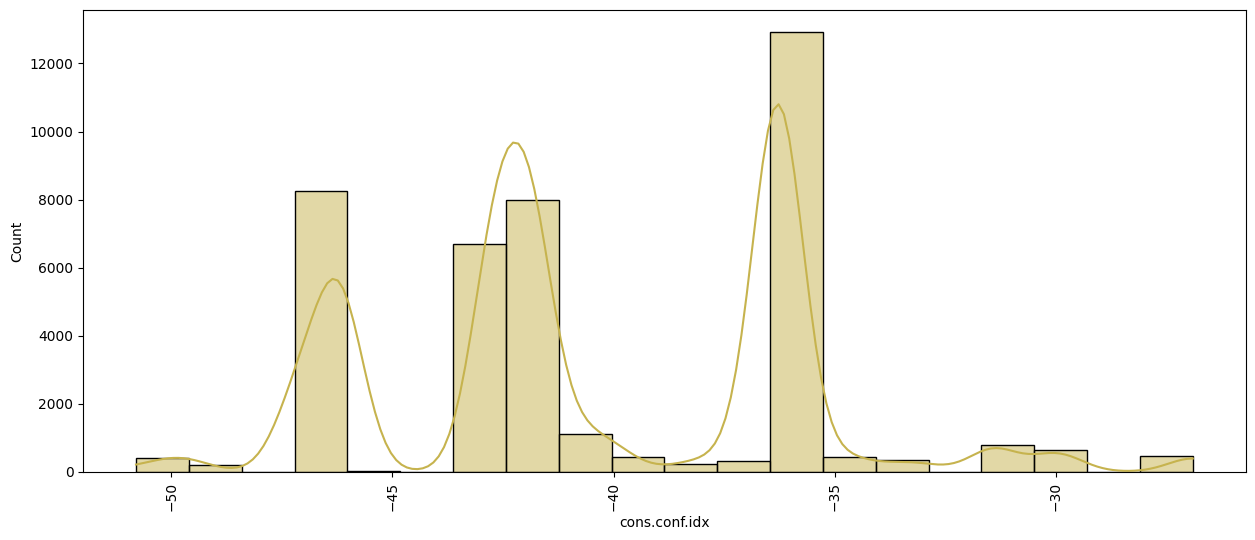

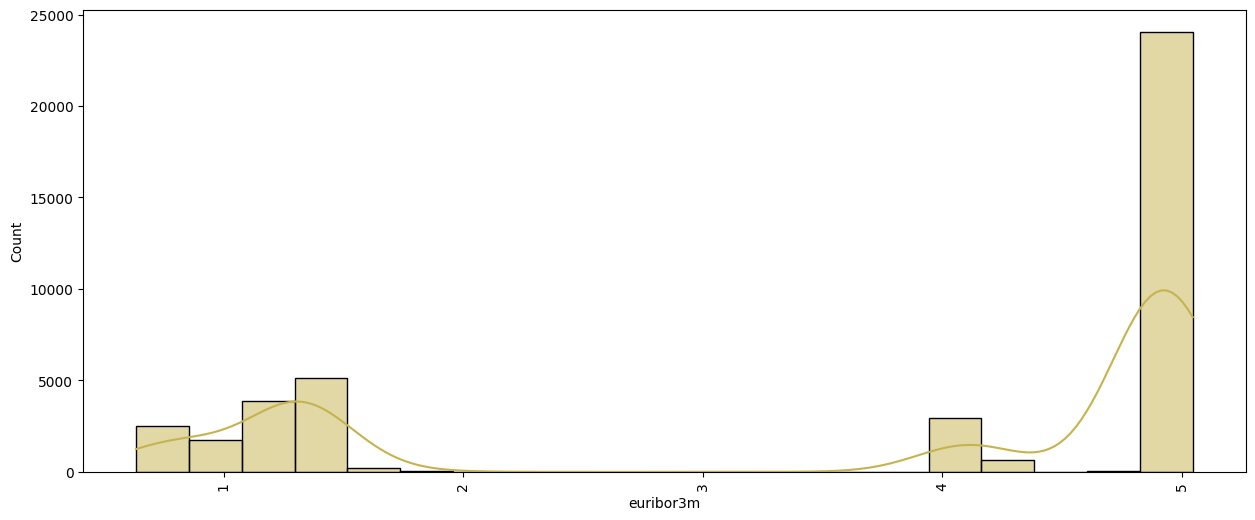

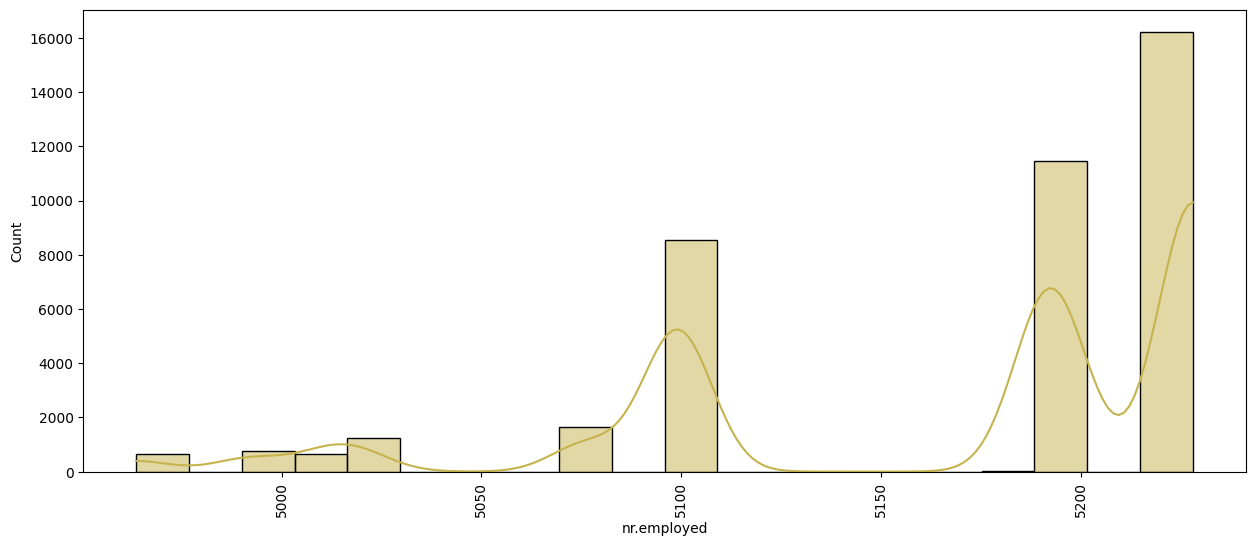

In [21]:

## Histogram - analysis is performed on numerical variables


for column in df_numeric.columns:
    plt.figure(figsize=(15,6))
    sns.histplot(df_numeric[column], kde = True, bins = 20, palette = 'hls')
    plt.xticks(rotation =90)
    plt.show()


## This histogram shows:
#1.based on the job : major participants are from admin, bluecollar, technician, services and medium level from management, self-employed, enterpreneur
#2.Martial status : Major contributions from married, followed by single and then divorced
#3.education :Majorly Uni degree, high school, basic 9y, professional course.
#4.defaulters : Mostly no, then unknown
#5.housing :equal participation of yes and no
#6.Loan : Mostly no loan and then followed by having loans
#7.contacts: majority of the contacts are via cell phone and slightly lesser percentage on Phones
#8.Months: More participation is seen in May, june, july, aug and nov. Other months there is no significance.
#9#.days of week : Weekdays are predominantly used
#10. call duration: higher call duration participation is more
#11. campaign : around 35K people contacted during campaign
#12. pdays: Most of the ppl were contacted around 1000days after the last campaign
#13. previous: less than 10k people were contacted before campaign
#14.poutcome: Most of the participants outcome from previous campaign was not exists



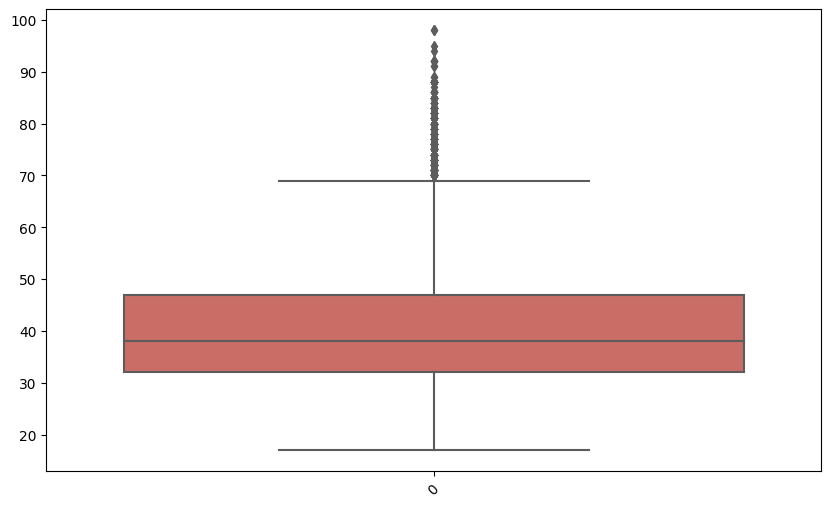

Outliers: 0        56
1        57
2        37
3        40
4        56
         ..
41183    73
41184    46
41185    56
41186    44
41187    74
Name: age, Length: 39781, dtype: int64
Number of Outliers: 39781
Minimum Outlier: 17
Maximum Outlier: 98


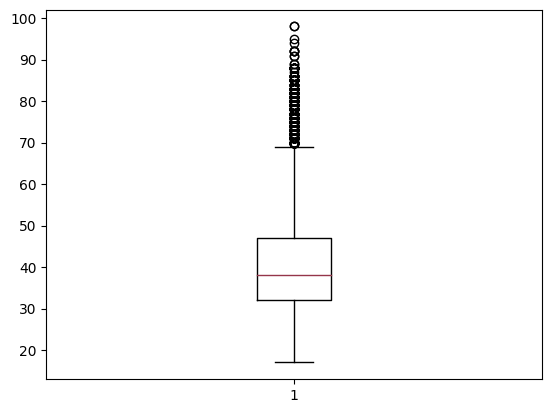

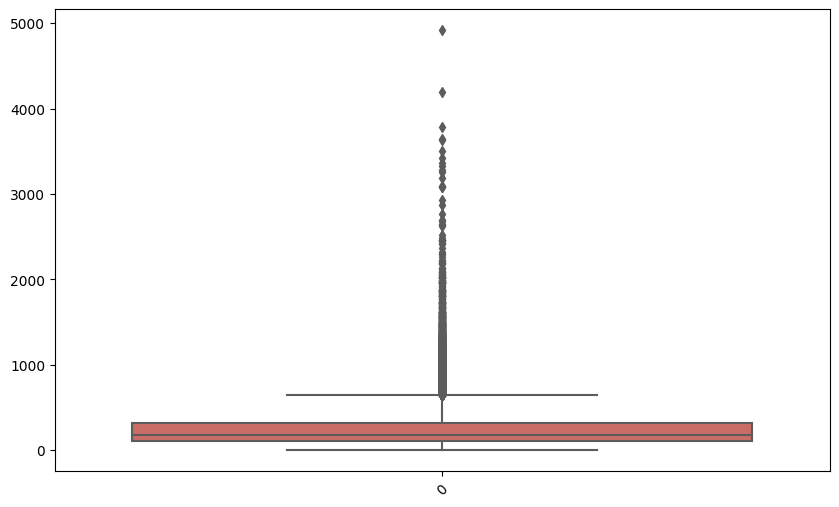

Outliers: 0        261
1        149
2        226
3        151
4        307
        ... 
41183    334
41184    383
41185    189
41186    442
41187    239
Name: duration, Length: 41071, dtype: int64
Number of Outliers: 41071
Minimum Outlier: 0
Maximum Outlier: 4918


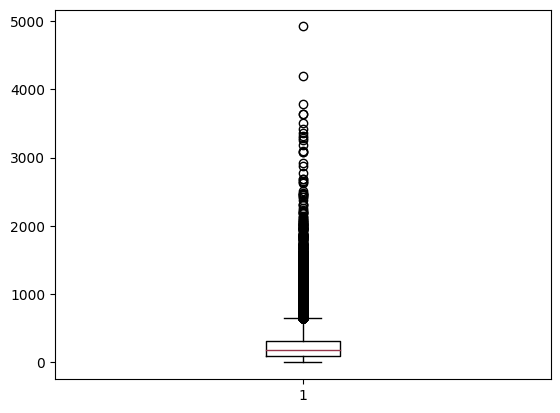

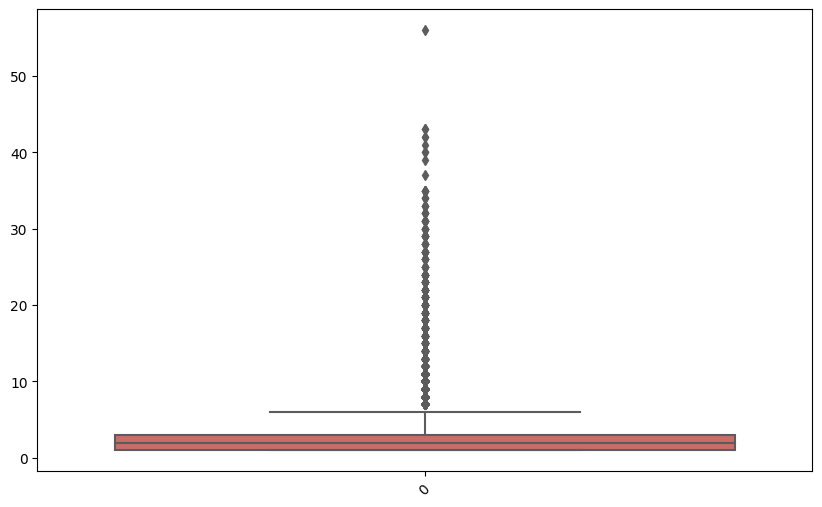

Outliers: 0        1
1        1
2        1
3        1
4        1
        ..
41182    1
41183    1
41184    1
41186    1
41187    3
Name: campaign, Length: 30618, dtype: int64
Number of Outliers: 30618
Minimum Outlier: 1
Maximum Outlier: 56


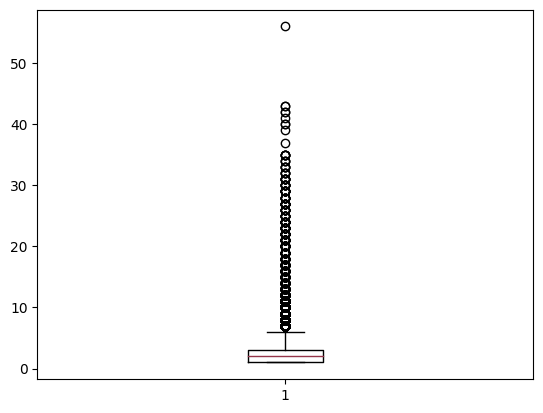

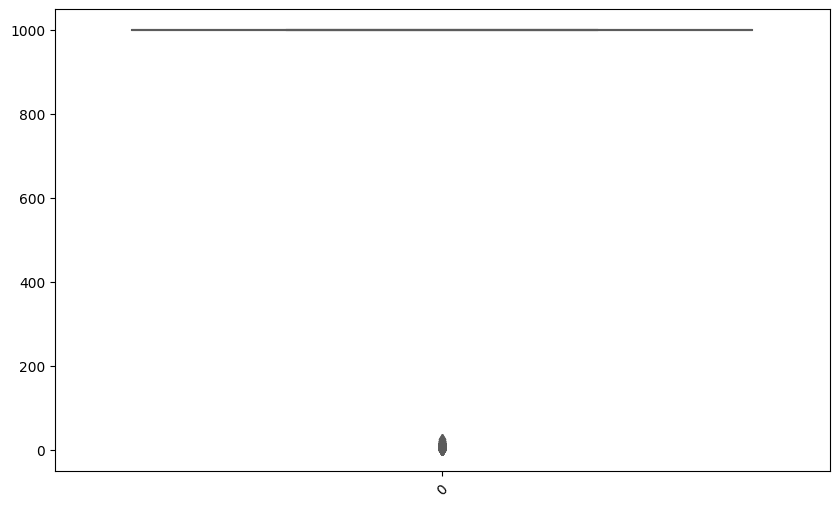

Outliers: 24108     6
24264     4
24279     4
24397     3
24482     4
         ..
41163     4
41164    10
41174     1
41178     6
41182     9
Name: pdays, Length: 1515, dtype: int64
Number of Outliers: 1515
Minimum Outlier: 0
Maximum Outlier: 27


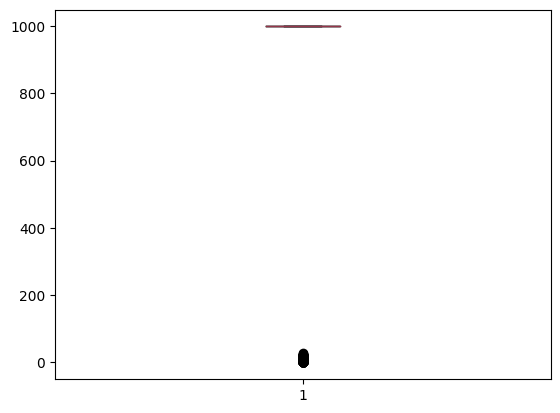

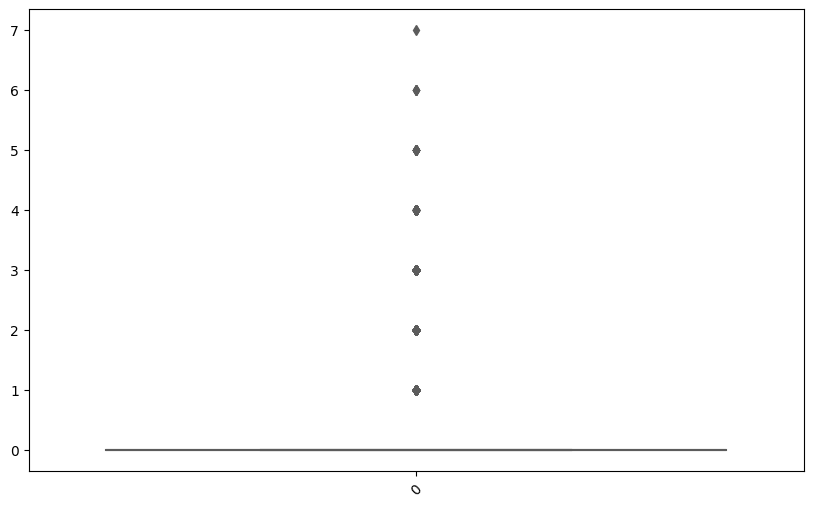

Outliers: 24013    1
24019    1
24076    1
24102    1
24108    1
        ..
41174    6
41175    2
41178    3
41182    1
41187    1
Name: previous, Length: 5625, dtype: int64
Number of Outliers: 5625
Minimum Outlier: 1
Maximum Outlier: 7


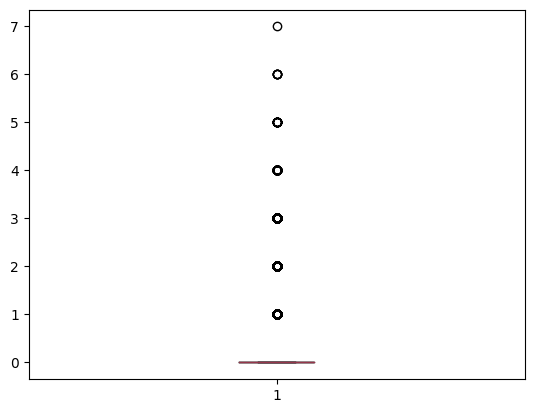

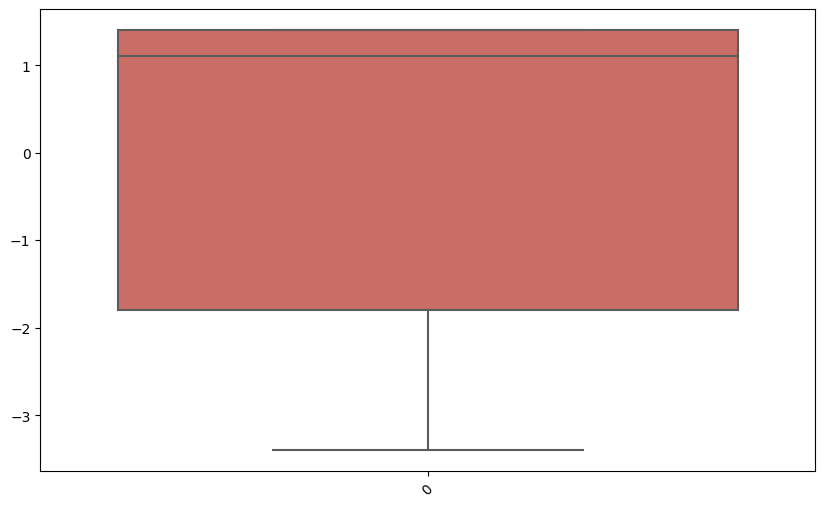

Outliers: 7763     1.4
7764     1.4
7765     1.4
7766     1.4
7767     1.4
        ... 
41183   -1.1
41184   -1.1
41185   -1.1
41186   -1.1
41187   -1.1
Name: emp.var.rate, Length: 33425, dtype: float64
Number of Outliers: 33425
Minimum Outlier: -3.4
Maximum Outlier: 1.4


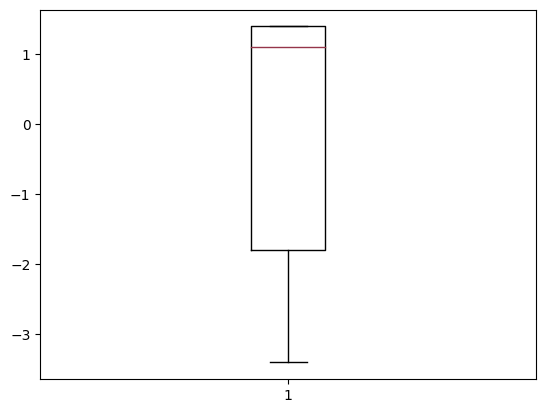

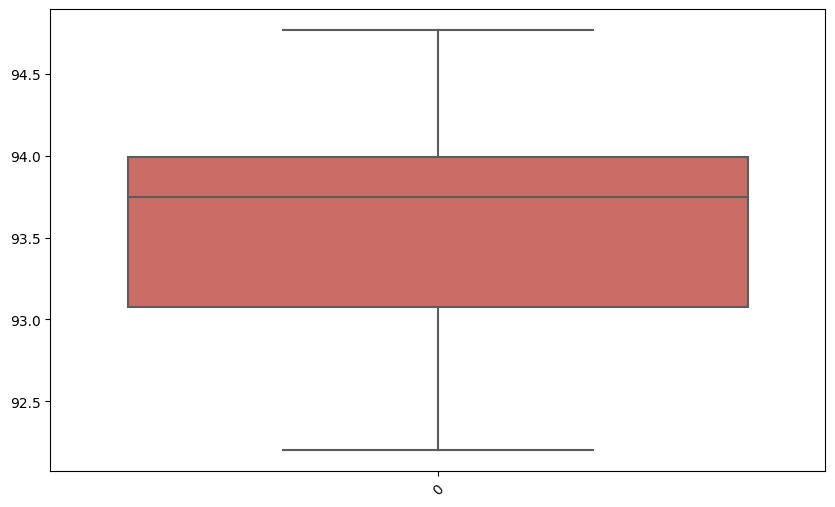

Outliers: 0        93.994
1        93.994
2        93.994
3        93.994
4        93.994
          ...  
41183    94.767
41184    94.767
41185    94.767
41186    94.767
41187    94.767
Name: cons.price.idx, Length: 41014, dtype: float64
Number of Outliers: 41014
Minimum Outlier: 92.201
Maximum Outlier: 94.767


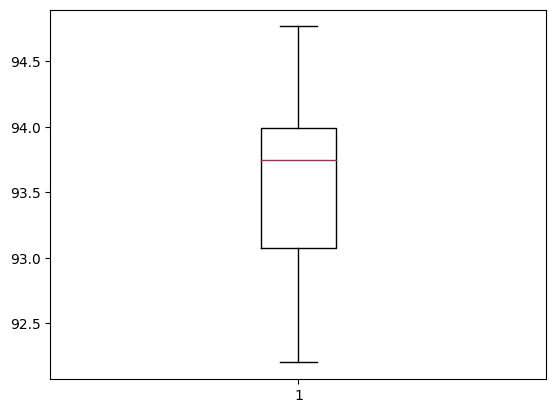

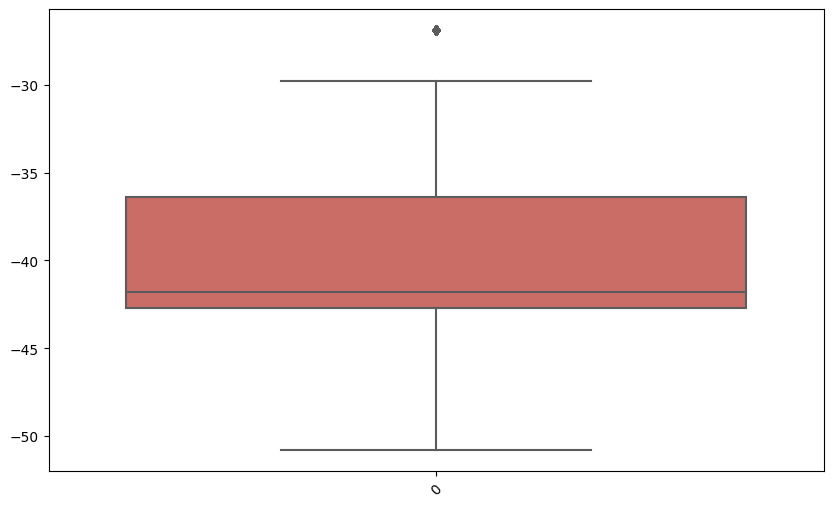

Outliers: 0       -36.4
1       -36.4
2       -36.4
3       -36.4
4       -36.4
         ... 
41183   -50.8
41184   -50.8
41185   -50.8
41186   -50.8
41187   -50.8
Name: cons.conf.idx, Length: 36814, dtype: float64
Number of Outliers: 36814
Minimum Outlier: -50.8
Maximum Outlier: -26.9


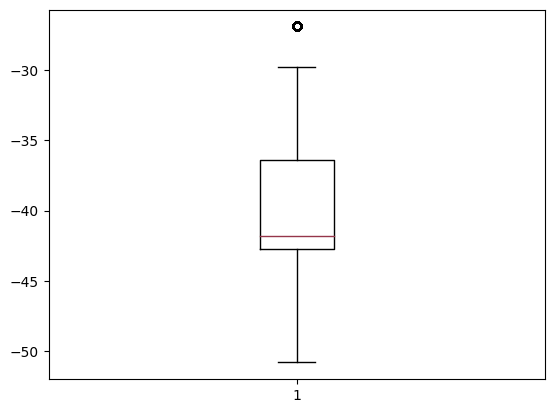

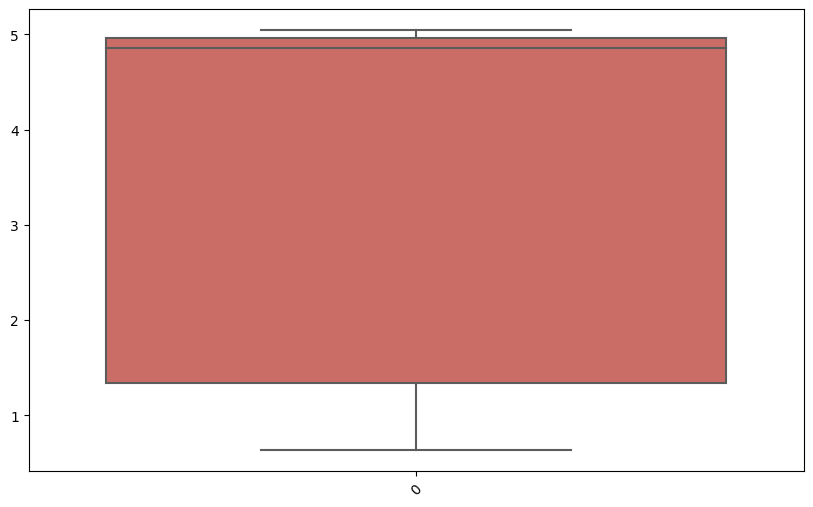

Outliers: 756      4.856
757      4.856
758      4.856
759      4.856
760      4.856
         ...  
41183    1.028
41184    1.028
41185    1.028
41186    1.028
41187    1.028
Name: euribor3m, Length: 38320, dtype: float64
Number of Outliers: 38320
Minimum Outlier: 0.634
Maximum Outlier: 5.045


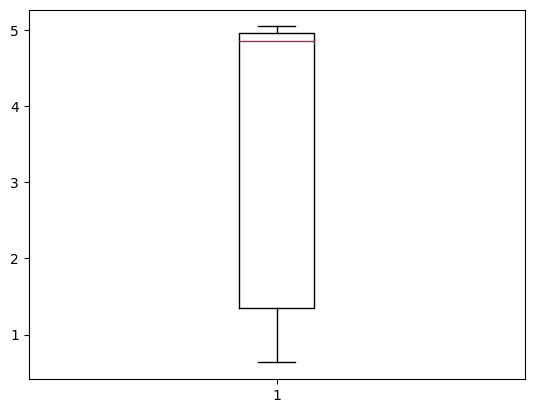

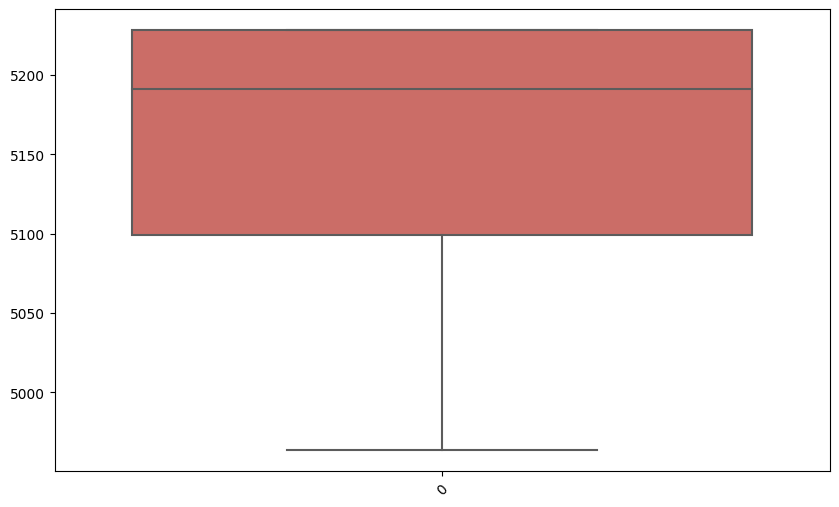

Outliers: 7763     5228.1
7764     5228.1
7765     5228.1
7766     5228.1
7767     5228.1
          ...  
41183    4963.6
41184    4963.6
41185    4963.6
41186    4963.6
41187    4963.6
Name: nr.employed, Length: 33425, dtype: float64
Number of Outliers: 33425
Minimum Outlier: 4963.6
Maximum Outlier: 5228.1


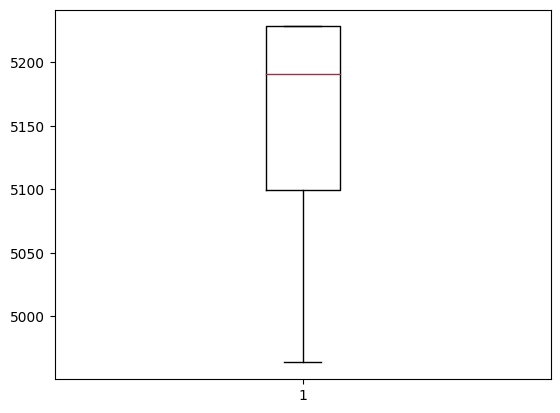

In [22]:
##BOX Plot on numerical values


for column in df_numeric.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(df[column], palette = 'hls')
#    plt.title('Boxplot for {column}')
    plt.xticks(rotation =45)
    plt.show()
    q1, q3 = plt.boxplot(df_numeric[column])['medians'][0].get_ydata()
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = df_numeric[column][(df_numeric[column] < lower_limit) | (df_numeric[column] > upper_limit)]
    outlier_count = len(outliers)
    print("Outliers:", outliers)
    print("Number of Outliers:", outlier_count)

    if len(outliers) > 0:
       min_outlier = min(outliers)
       max_outlier = max(outliers)
       print("Minimum Outlier:", min_outlier)
       print("Maximum Outlier:", max_outlier)
    else:
       print("No outliers found.")




## Duration - Since the box is small,jj it shows less variability. Middle value of the dataset is around 200. The data seems positively skewed.
## Around 80% of the dataset has outliers, so it indicates most of the customers are contacted and had call duration for longertime. Duration of 0 is present as even not attended calls are present
# So removing the records that has 0 values for time is a good choice ? or these rows give insight that call duration with 0 will have the target value as 'no'?

## campaign (number of contacts made during this campaign).
#min outlier -1 and max - 56, making avg number of contacts to less than 10


##pdays (number of days that passed by after the client was last contacted from a previous campaign) min - 0, max - 27


##previous: number of contacts performed before this campaign and for this client
#max was 7 contacts

##employment variation rate - quarterly indicator (numeric)employment variation rate - quarterly indicator (numeric)





<Figure size 1500x600 with 0 Axes>

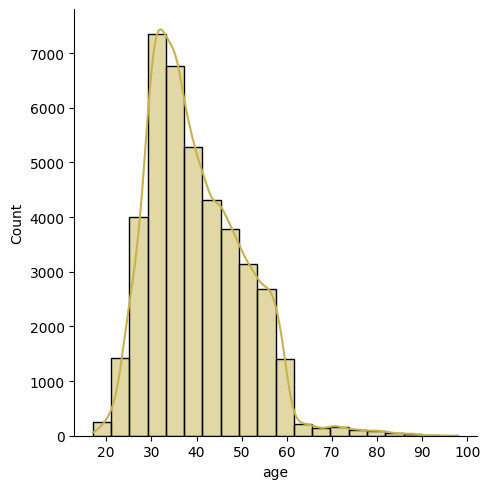

<Figure size 1500x600 with 0 Axes>

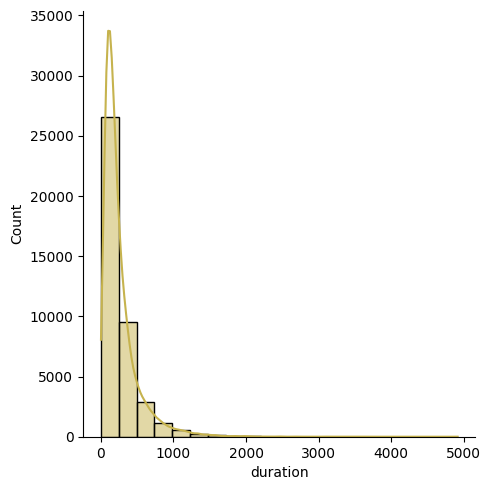

<Figure size 1500x600 with 0 Axes>

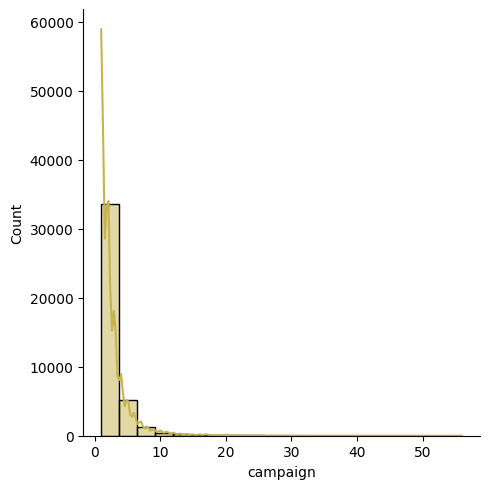

<Figure size 1500x600 with 0 Axes>

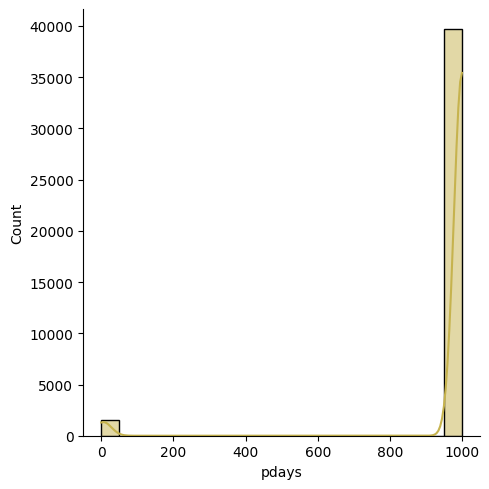

<Figure size 1500x600 with 0 Axes>

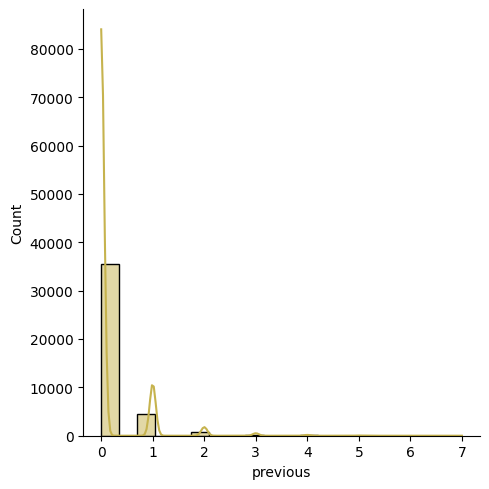

<Figure size 1500x600 with 0 Axes>

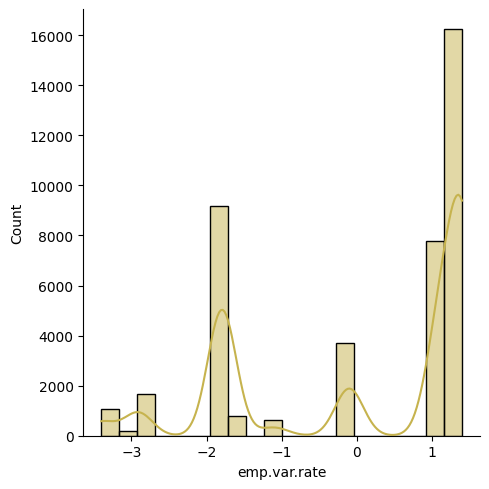

<Figure size 1500x600 with 0 Axes>

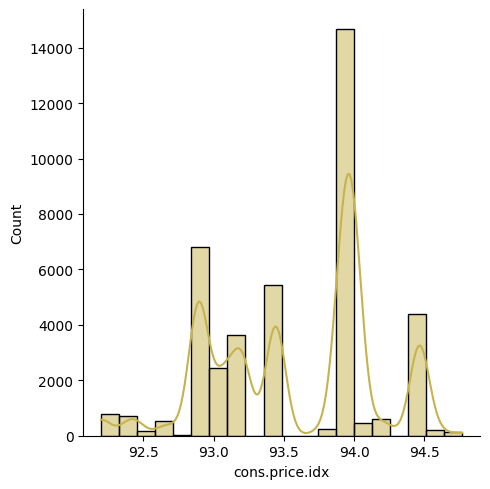

<Figure size 1500x600 with 0 Axes>

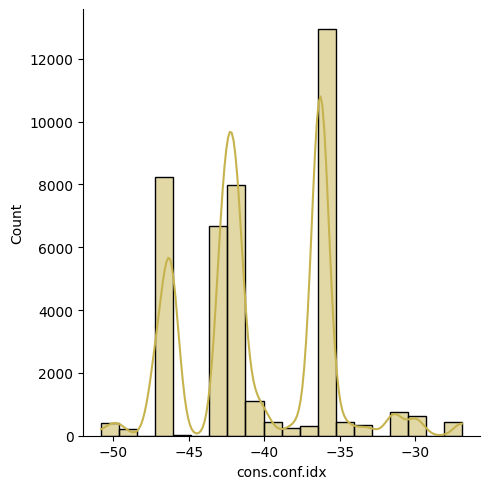

<Figure size 1500x600 with 0 Axes>

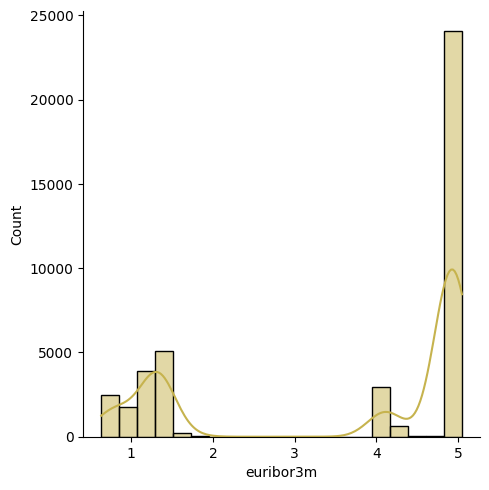

<Figure size 1500x600 with 0 Axes>

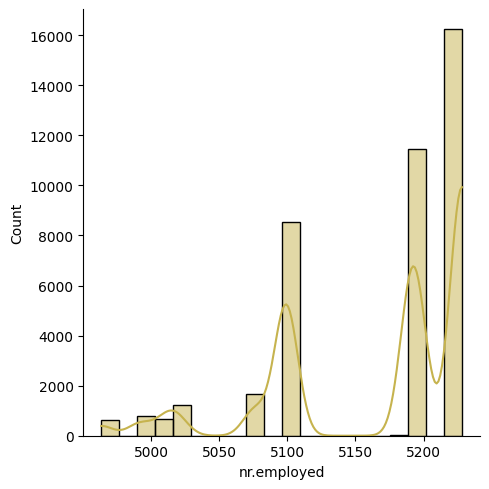

In [23]:
## Distribution plot

for columns in df_numeric:
    plt.figure(figsize=(15,6))
    sns.displot(df_numeric[columns], kde=True, bins = 20)
    plt.xticks(rotation =0)
    plt.show()

##none of the variables are normally distributed


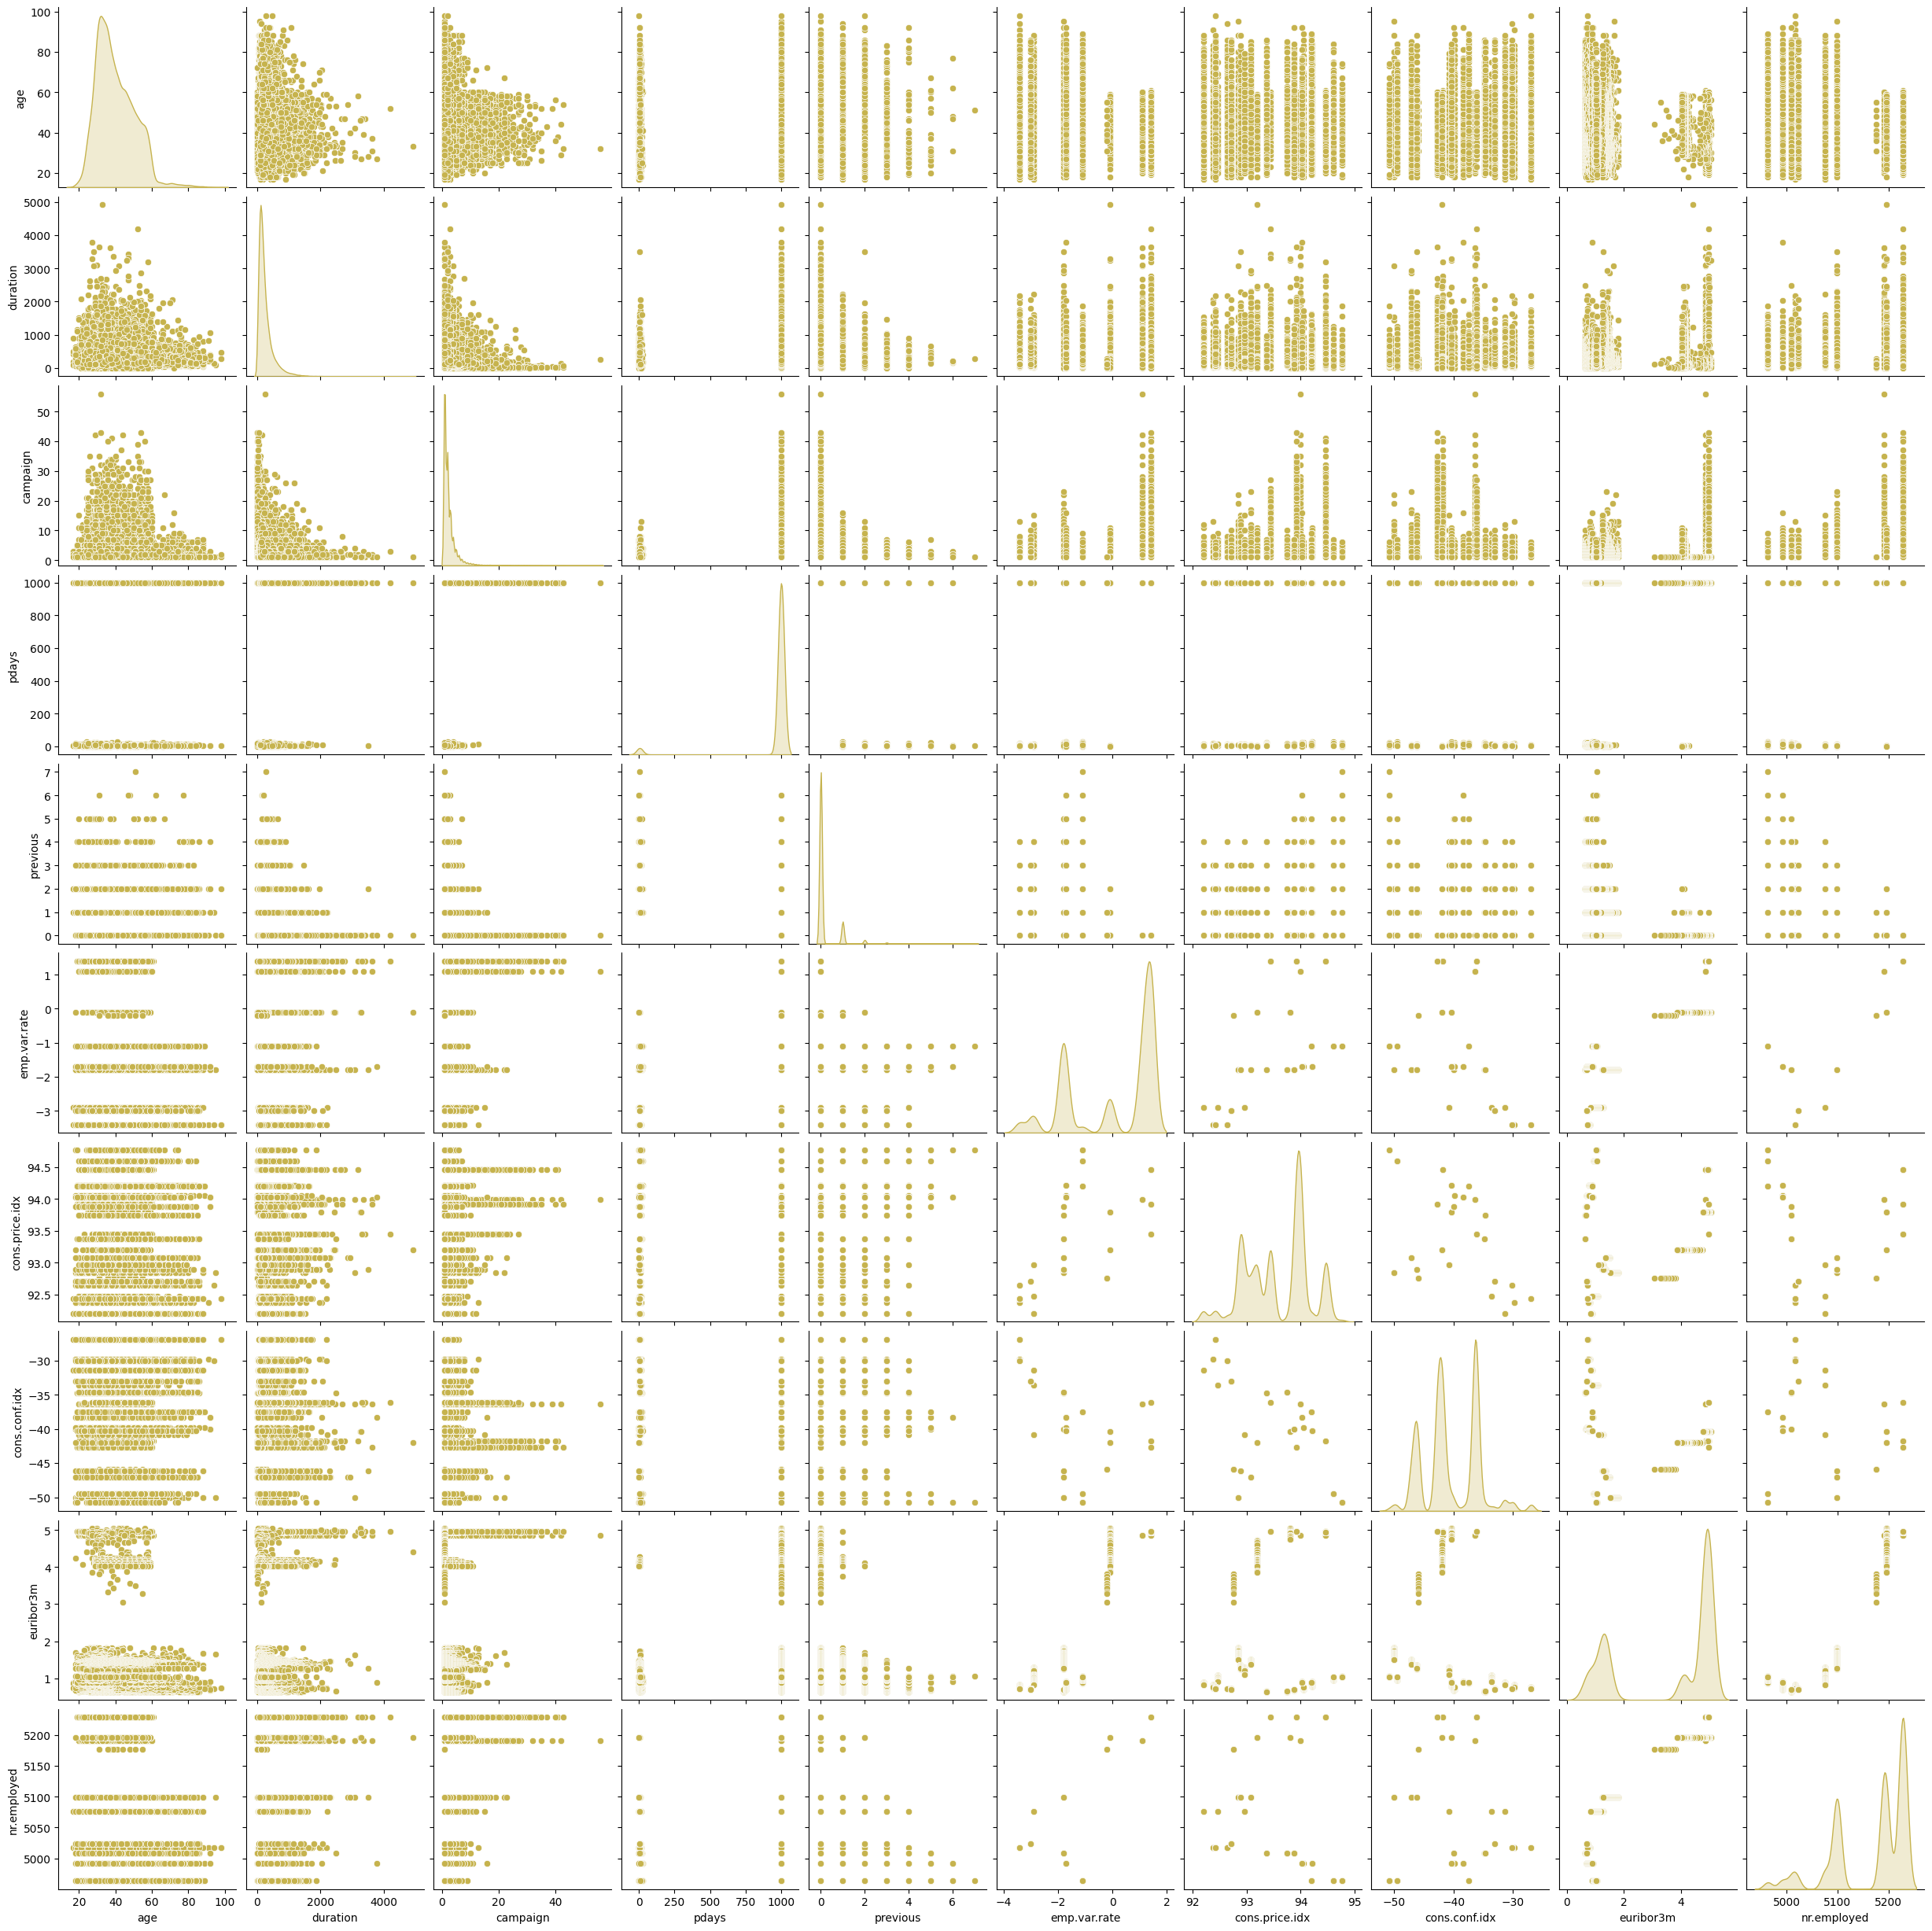

In [24]:
## scatter plot between only numeric features.

sns.pairplot(df_numeric, diag_kind='kde')

##nr.employed has positive relation with emp.var rate, cons price idx, cons conf idx,
##eurobor has non-linear relation with emp.var rate, nr.employed. cons price & cons conf has same pattern observed( non linear relationship )
##consconf has similar non linear relation with emp.var rate & cons.conf.non linear relation with euribor & nr. employed
#consprice has linear (positive) with emp var rate, negative linear relationship with cons conf. non linear with nr.employed & eurobor
##emp var has positive linear with consprice & nr employes.Negative relationship with consconf.non linear with euribor
##duration & campaign follows similar pattern with all other variables(non linear)
##pdays follows similar non linear relationship with all other variables


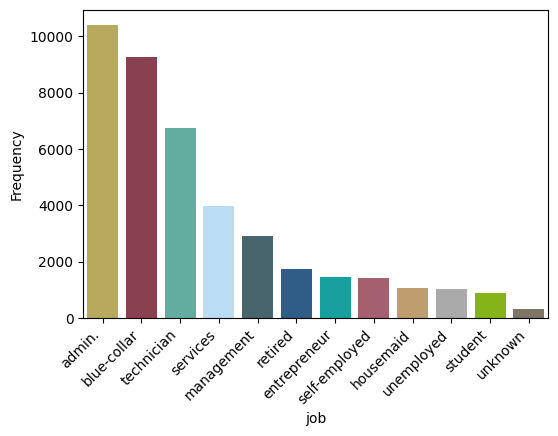

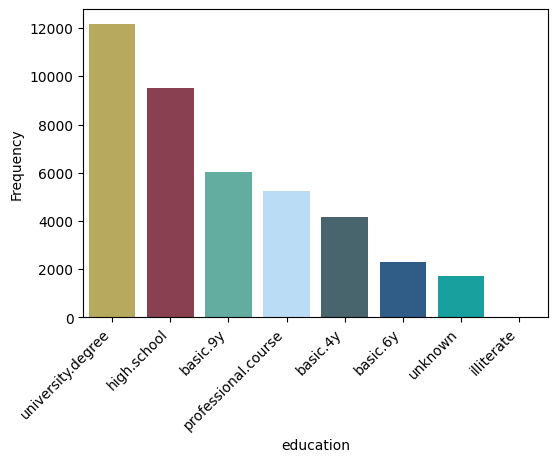

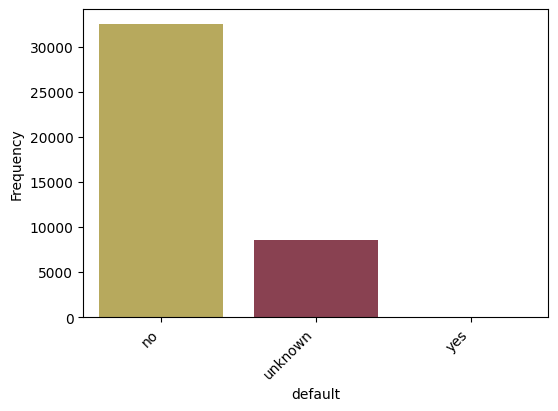

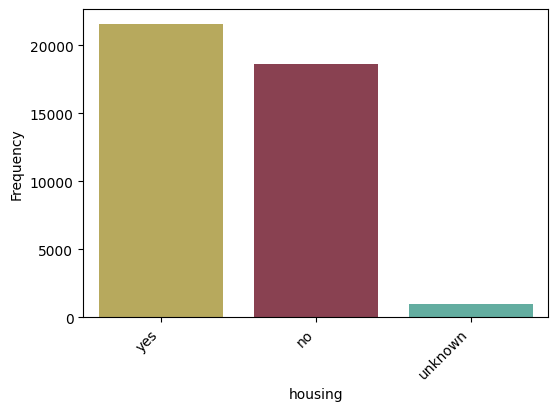

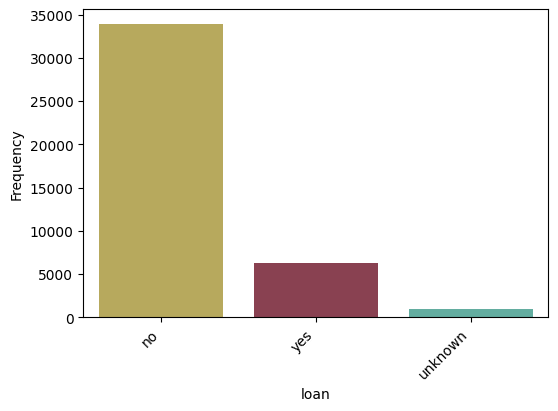

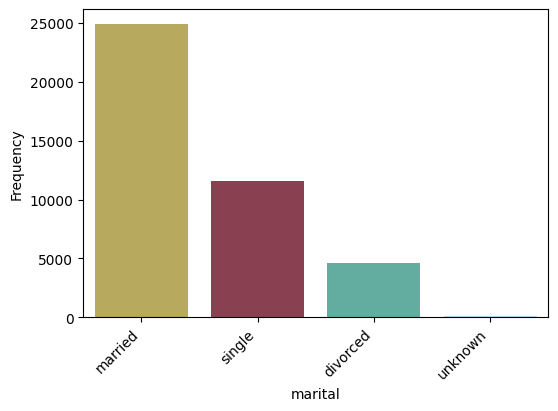

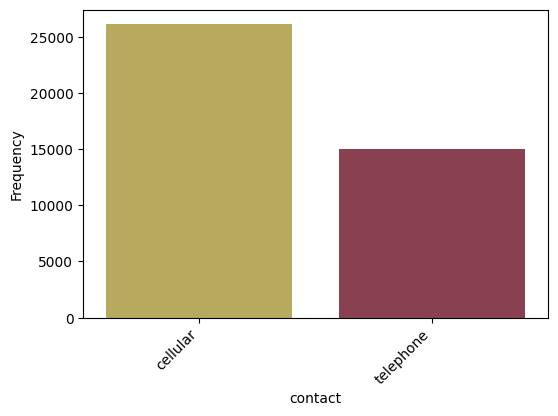

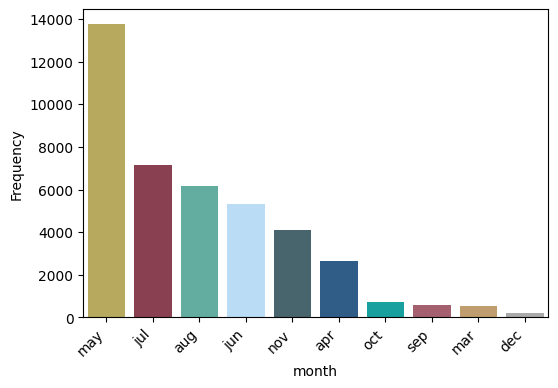

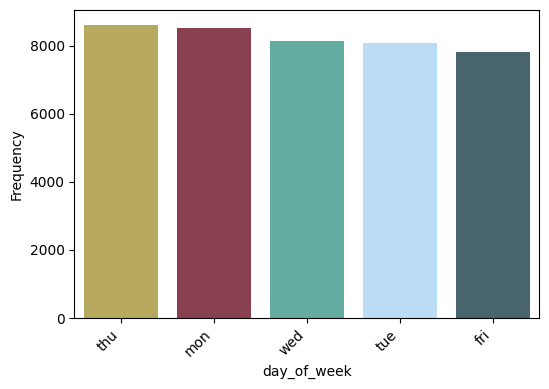

In [25]:
## data analysis for categorical variables
##Bar plot

df_bar = df[['job', 'education', 'default', 'housing', 'loan', 'marital', 'contact', 'month', 'day_of_week']]


for col in df_bar.columns:
     plt.figure(figsize=(6,4))
     ax = sns.barplot(x=df_bar[col].value_counts().index, y=df_bar[col].value_counts())

     # Rotate the x-axis labels diagonally
     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
     plt.title=(f'bar plot for {col}')
     plt.xlabel(col)
     plt.ylabel('Frequency')
     plt.show()


In [26]:
##implementing count and count% on categorical variables

for col in df_obj.columns:
    count = df_obj[col].value_counts()
    percentage = df_obj[col].value_counts(normalize=True) * 100
    print(col, count, percentage)



job admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64 admin.           25.303486
blue-collar      22.467709
technician       16.371273
services          9.636302
management        7.099155
retired           4.175974
entrepreneur      3.535010
self-employed     3.450034
housemaid         2.573565
unemployed        2.461882
student           2.124405
unknown           0.801204
Name: job, dtype: float64
marital married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64 married     60.522482
single      28.085850
divorced    11.197436
unknown      0.194231
Name: marital, dtype: float64
education university.degree      12168
high.school             9515
basic.9y                6045
professional.course    

In [27]:


# Create a two-way table of counts

for col in df_obj:
    cross_tab = pd.crosstab(df[col], df['y'])

# Calculate percentages
    percentage = cross_tab.apply(lambda r: r / r.sum(), axis=1) * 100

# Create a summary DataFrame with counts and percentages
    summary = pd.concat([cross_tab, percentage], axis=1, keys=['Count', 'Percentage (%)'])

    print(summary)



              Count       Percentage (%)           
y                no   yes             no        yes
job                                                
admin.         9070  1352      87.027442  12.972558
blue-collar    8616   638      93.105684   6.894316
entrepreneur   1332   124      91.483516   8.516484
housemaid       954   106      90.000000  10.000000
management     2596   328      88.782490  11.217510
retired        1286   434      74.767442  25.232558
self-employed  1272   149      89.514426  10.485574
services       3646   323      91.861930   8.138070
student         600   275      68.571429  31.428571
technician     6013   730      89.173958  10.826042
unemployed      870   144      85.798817  14.201183
unknown         293    37      88.787879  11.212121
          Count       Percentage (%)           
y            no   yes             no        yes
marital                                        
divorced   4136   476      89.679098  10.320902
married   22396  2532      8

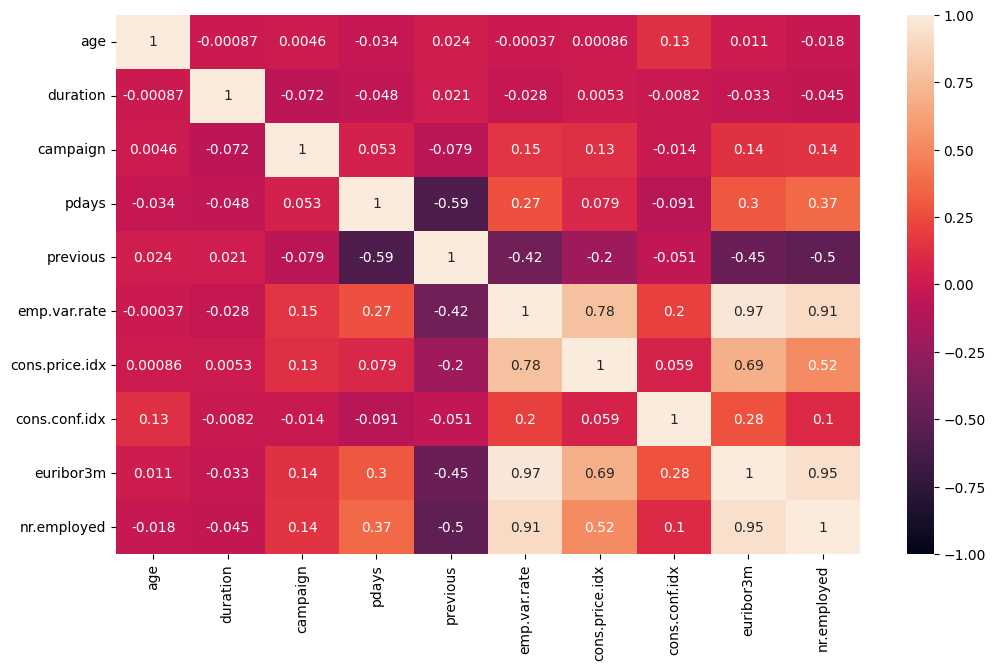

In [28]:
##heat map

plt.figure(figsize=(12, 7))
sns.heatmap(df.corr(), annot = True, vmin = -1, vmax = 1)
plt.show()


#From the Heat map, we can infer the following:
# pdays has negative correlation with previous
# emp.var.rate is highly positively correlated with nr.employed & euribor3m and consprice
#previous is negatively correlated with nr.employed and euribor3m
#cons.price is positively correlated with emp var rate. also positively correlated with nr.employed and euribor
#euribor is highly positively correlated with nr.employed and cons.price , emp var rate
#nr employed is highly correlated with euribor3 & emp var rate. moderately correlated with cons price.

In [60]:

## If the value verbose = TRUE is not provided in the calling function, then default value false will be taken.
def basic_models1(data=[], verbose=False):
    models=[DecisionTreeClassifier( ),LogisticRegression(),
            RandomForestClassifier(),GradientBoostingClassifier( ), XGBClassifier()]

    if len(data)== 2:
       X_train, X_test, y_train, y_test = train_test_split(data[0],data[1],test_size = 0.25,random_state=123)

    else:
       X_train, X_test, y_train, y_test = data[0],data[1],data[2],data[3]


    #Instantiate lists to store each of the models results
    accuracy = []
    f1 = []
    roc_auc = []
    recall = []
    precision = []
    #Run thorugh each of the models to get their performance metrics
    for model in models:
       clf = model
       k = 5
       f1_mean = np.mean(cross_val_score(model, X_train, y_train, cv=k, scoring='f1'))
       accuracy_mean = np.mean(cross_val_score(model, X_train, y_train, cv=k, scoring='accuracy'))
       roc_auc_mean = np.mean(cross_val_score(model, X_train, y_train, cv=k, scoring='roc_auc'))
       recall_mean = np.mean(cross_val_score(model, X_train, y_train, cv=k, scoring='recall'))
       precision_mean = np.mean(cross_val_score(model, X_train, y_train, cv=k, scoring='precision'))
       f1.append(f1_mean)
       accuracy.append(accuracy_mean)
       roc_auc.append(roc_auc_mean)
       recall.append(recall_mean)
       precision.append(precision_mean)

       if verbose:
            print('Classification Model: ',model,'\n')
            print(classification_report(y_test, test_preds),'\n')
    #store results in dataframe
    results = pd.DataFrame([f1,roc_auc, accuracy, precision,recall],
                          index= ['f1','roc_auc','accuracy','precision','recall',],
                          columns=['DecisionTree','LogisticRegression','RandomForest','Gradient Boosting', 'XG Boost'])

    #Change orientation of the dataframe
    return f1,roc_auc, accuracy, precision,recall,results.transpose()


In [30]:
type(df['age'])
print(y)


0         no
1         no
2         no
3         no
4         no
        ... 
41183    yes
41184     no
41185     no
41186    yes
41187     no
Name: y, Length: 41188, dtype: object


In [31]:
## build the model using all the parameters and check the performance -- MODEL 1

warnings.filterwarnings('ignore')
def pipeline_transform_data(X, y):
    # Converting categorical variables to numeric data
    cat_pipeline = Pipeline(
        steps=[('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot encoding', OneHotEncoder(handle_unknown='ignore'))
    ]
    )

# Scaling numerical features and filling missing values
    num_pipeline = Pipeline(
        steps=[('impute', SimpleImputer(strategy='mean')),
          ('scale', StandardScaler())
    ]
    )

    # Numerical and categorical feature names
    cat_cols = X.select_dtypes(exclude='number').columns
    num_cols = X.select_dtypes(include='number').columns
    print('Categorical columns:\n', cat_cols);print()
    print('Numeric columns:\n',num_cols)

# Combining the two pipelines with a column transformer
    from sklearn.compose import ColumnTransformer

    full_pipeline = ColumnTransformer(
         transformers=[
             ('numeric', num_pipeline, num_cols),
             ('categorical', cat_pipeline, cat_cols)
    ]
    )

    # encode the target label
    le = LabelEncoder()
    y = le.fit_transform(y)

# get mapping for each label
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print('\n', le_name_mapping)

# Fitting the pipeline
    X_ = full_pipeline.fit_transform(X, y)

# Retrieve column names after applying ColumnTransformer
    cat_encoder = full_pipeline.named_transformers_['categorical']
    cat_one_hot_encoder = cat_encoder.named_steps['one-hot encoding']
# Get the transformed feature names from OneHotEncoder
    cat_feature_names = cat_one_hot_encoder.get_feature_names_out(cat_cols)

# Combine numerical and categorical feature names
    feature_names = list(num_cols) + list(cat_feature_names)

# Create DataFrames with correct column names
    X_df = pd.DataFrame(X_, columns=feature_names)
    y_df = y

    return X_df, y_df


In [62]:
## separate input features and output
X = df.drop(['y'], axis =1)
y = df['y']

In [ ]:
print(X)

In [63]:
##building first model

#warnings.filterwarnings('ignore')

X, y = pipeline_transform_data(X, y)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,stratify=y,random_state=123)

## the training and testing data is moved to the data label for the model function to execute it
data = [X_train, X_test, y_train, y_test]

f1_1,roc_auc_1, accuracy1, precision1,recall1,results1 = basic_models1(data=[X_train, X_test, y_train, y_test])
results1.sort_values('roc_auc',ascending=False)

print(results1)


print('Best Model per Metric')
for metric in results1.columns:
    print(f'{metric.capitalize()}:',results1.sort_values(metric,ascending=False).index[0])

Categorical columns:
 Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

Numeric columns:
 Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

 {'no': 0, 'yes': 1}
                          f1   roc_auc  accuracy  precision    recall
DecisionTree        0.511029  0.724284  0.888155   0.506344  0.520977
LogisticRegression  0.517881  0.934369  0.911236   0.666717  0.423563
RandomForest        0.535631  0.939460  0.912563   0.661766  0.450862
Gradient Boosting   0.582682  0.946395  0.915801   0.660087  0.521839
XG Boost            0.579682  0.945734  0.912305   0.630299  0.536782
Best Model per Metric
F1: Gradient Boosting
Roc_auc: Gradient Boosting
Accuracy: Gradient Boosting
Precision: LogisticRegression
Recall: XG Boost


In [64]:
print(f1_1,roc_auc_1, accuracy1, precision1,recall1)

[0.5110292294603269, 0.517880914742335, 0.5356313726730823, 0.5826818416064004, 0.5796819312485789] [0.72428413316347, 0.9343686745948215, 0.9394600767662119, 0.9463952009384162, 0.9457338117361127] [0.8881551727724064, 0.9112362642270776, 0.9125634707853243, 0.915800743451108, 0.9123046130360087] [0.5063437526455912, 0.6667172081277165, 0.6617663792900965, 0.6600867526466803, 0.6302994699790058] [0.5209770114942529, 0.4235632183908046, 0.4508620689655173, 0.5218390804597701, 0.5367816091954023]


In [39]:
##run chi-sq test For categorical variables
print(df)
from scipy.stats import chi2_contingency
!pip install scipy

# Create an empty DataFrame to store the p-values
chi2_results = pd.DataFrame(index=df_obj_cols1, columns=df_obj_cols1)
significance_level = 0.05
related_fields = []
not_related_fields = []

# Iterate through all pairs of categorical variables
for col1 in df_obj_cols1:
    for col2 in df_obj_cols1:
        if col1 != col2:
            contingency_table = pd.crosstab(df[col1], df[col2])
            _, p, _, _ = chi2_contingency(contingency_table)
            chi2_results.loc[col1, col2] = p
            if p < significance_level:
                related_fields.append((col1, col2))
            else:
                not_related_fields.append((col1,col2))




#print(chi2_results)
print("Related Fields:")
for field_pair in related_fields:
    print(f"{field_pair[0]} and {field_pair[1]} are related.")

print("Not Related Fields:")
for field_pair in not_related_fields:
    print(f"{field_pair[0]} and {field_pair[1]} are not related.")


       age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  ...  campaign  

In [40]:
def plot_feature_importance(clf,index):
    '''Plot the 0 most important features for a classifier model in a bar chart
    according to importance'''
    feature_importances = pd.DataFrame(clf.feature_importances_, index=index, columns=['Score'])
    feature_importances = feature_importances.sort_values(by='Score',ascending=True).tail(15)
    feature_importances.plot(kind='barh', title='Top 10 Important Features',legend=False)
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show();

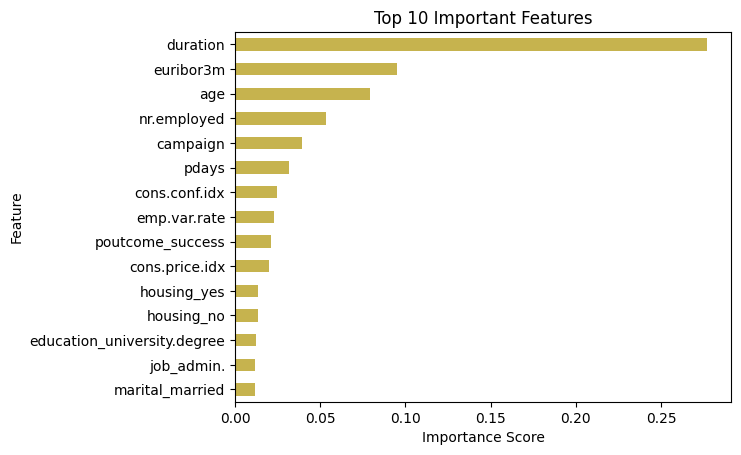

Number of data rows in the training set: 30891
Number of data rows in the test set: 10297
x_Train cols: Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'mo

In [41]:
#Identifying the top 10 features

!pip install matplotlib
import matplotlib.pyplot as plt
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
plot_feature_importance(clf,X.columns)

 # For the training set
num_train_samples = X_train.shape[0]
print("Number of data rows in the training set:", num_train_samples)

    # For the test set
num_test_samples = X_test.shape[0]
print("Number of data rows in the test set:", num_test_samples)

print('x_Train cols:', X_train.columns)


In [42]:
## separate input features and output
X = X.iloc[0:0]
y = 0

X = df.drop(['y'], axis =1)
y = df['y']

print(X)

print(y)

print(X_resampled.columns)

       age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  duration  campa

NameError: ignored

In [43]:

##implement smote technique as the dataset is imbalanced


##Prepare dataset for SMOTE
from imblearn.over_sampling import SMOTE, SMOTENC
categorical_features = X.select_dtypes(exclude='number').columns
continuous_features = X.select_dtypes(include='number').columns



# Separate features into categorical and continuous
categorical_features =[X.columns.get_loc(col) for col in categorical_features]
continuous_features = [X.columns.get_loc(col) for col in continuous_features]

print(categorical_features)
print(continuous_features)

# Apply SMOTE to categorical features using SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_resampled_cat1, y_resampled_cat1 = smote_nc.fit_resample(X, y)

print('X_resampled_cat1:',X_resampled_cat1)
print('X_resampled_cat1 cols:', X_resampled_cat1.columns)
print('smote_nc:', smote_nc)


# Apply SMOTE to continuous features
smote = SMOTE(random_state=42)
X_resampled_cont1, y_resampled_cont1 = smote.fit_resample(X.iloc[:,continuous_features], y)

print('X_resampled_cont1:', X_resampled_cont1)
print('X_resampled_cont1:',X_resampled_cont1.columns)

# Merge the resampled data
X_resampled1 = pd.concat([pd.DataFrame(X_resampled_cat1, columns=X.columns[categorical_features]),
                               pd.DataFrame(X_resampled_cont1, columns=X.columns[continuous_features])], axis=1)
y_resampled1 = y_resampled_cat1

[1, 2, 3, 4, 5, 6, 7, 8, 9, 14]
[0, 10, 11, 12, 13, 15, 16, 17, 18, 19]
X_resampled_cat1:        age            job  marital          education  default housing loan  \
0       56      housemaid  married           basic.4y       no      no   no   
1       57       services  married        high.school  unknown      no   no   
2       37       services  married        high.school       no     yes   no   
3       40         admin.  married           basic.6y       no      no   no   
4       56       services  married        high.school       no      no  yes   
...    ...            ...      ...                ...      ...     ...  ...   
73091   48         admin.  married  university.degree       no      no   no   
73092   37    blue-collar  married           basic.6y       no      no   no   
73093   26         admin.   single        high.school       no      no   no   
73094   78        retired  married           basic.4y       no     yes   no   
73095   39  self-employed  married       

In [44]:
print(X_resampled1.columns)
print(X_resampled1.shape[1])

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'age', 'duration', 'campaign',
       'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed'],
      dtype='object')
20


In [45]:
##Set up the data for the 2nd model

X = X_resampled1
y = y_resampled1

##check data type of X
print(type(X))

# Check total number of records in y
total_records = y.shape[0]
print('Total records:', total_records)

#check the total number of y values having 0 and total having 1
value_counts = y.value_counts()
print(f'count of deposit being 0: {value_counts[0]}')
print(f'count of deposit being 1:{value_counts[1]}')


<class 'pandas.core.frame.DataFrame'>
Total records: 73096
count of deposit being 0: 36548
count of deposit being 1:36548


In [46]:
print(df.columns)
print(df.shape[1])

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')
21


In [47]:
print(X.columns)
print(X.shape[1])

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'age', 'duration', 'campaign',
       'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed'],
      dtype='object')
20


In [48]:
##Build model on resampled data

# X & y has resampled data , so call the pipeline process now

X, y = pipeline_transform_data(X, y)

# On return from pipeline_transform X & y will have transformed data.

X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X ,
                                                                                            y, random_state=101, test_size=0.25)
## the training and testing data is moved to the data label for the model function to execute it

data = [X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled]



results2 = basic_models1(data=[X_train, X_test, y_train, y_test])
results2.sort_values('roc_auc',ascending=False)

print(results2)

print('Best Model per Metric')
for metric in results2.columns:
    print(f'{metric.capitalize()}:',results2.sort_values(metric,ascending=False).index[0])

Categorical columns:
 Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

Numeric columns:
 Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

 {'no': 0, 'yes': 1}
                          f1   roc_auc  accuracy  precision    recall
DecisionTree        0.511251  0.728049  0.888090   0.506211  0.516379
LogisticRegression  0.517881  0.934369  0.911236   0.666717  0.423563
RandomForest        0.532189  0.939096  0.911787   0.674430  0.441954
Gradient Boosting   0.582913  0.946393  0.915801   0.659841  0.521839
XG Boost            0.579682  0.945734  0.912305   0.630299  0.536782
Best Model per Metric
F1: Gradient Boosting
Roc_auc: Gradient Boosting
Accuracy: Gradient Boosting
Precision: RandomForest
Recall: XG Boost


In [52]:
X = df.drop(['y'], axis =1)
y = df['y']


In [53]:
##Implement Anova test
anova_results = pd.DataFrame(columns=['variable' , 'F-statistic' , 'p-value'])

# Loop through the continuous variables and perform ANOVA for each
for col in df_num_cols:

    group_data = [df[df['y'] == class_label][col] for class_label in df['y'].unique()]

    f_statistic, p_value = stats.f_oneway(*group_data)

    anova_results = anova_results.append({'variable': col, 'F-statistic': f_statistic, 'p-value': p_value}, ignore_index=True)


alpha = 0.05
anova_results['Significant'] = anova_results['p-value'] < alpha
# Print or inspect the ANOVA results
print(anova_results)





         variable  F-statistic        p-value  Significant
0             age    38.094659   6.802136e-10         True
1        duration  8094.101634   0.000000e+00         True
2        campaign   182.156673   2.007780e-41         True
3           pdays  4861.173272   0.000000e+00         True
4        previous  2304.257088   0.000000e+00         True
5    emp.var.rate  4023.829925   0.000000e+00         True
6  cons.price.idx   778.589786  9.318965e-170         True
7   cons.conf.idx   124.409975   7.536665e-29         True
8       euribor3m  4309.479048   0.000000e+00         True
9     nr.employed  5926.610646   0.000000e+00         True


In [55]:
##all the continuous variables have significant association with continuous variables from anova test and also the top10 features also represent all continuous variables have importance
## So now need to look for categorical variables. From chi-sq test, it shows that y variable and housing, y & loans are not related.
##Also loan and housing are not related to many other input variables.

##so lets drop these 2 parameters and check the model efficiency.

df1 = df.drop(['loan', 'housing'],axis=1)


In [56]:
 X = df1.drop(['y'],axis =1)
 y =  df1['y']



In [57]:
##Build the 3rd model using the reduced dataset

# X & y has resampled data , so call the pipeline process now

X, y = pipeline_transform_data(X, y)

# On return from pipeline_transform X & y will have transformed data for the reduced dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,stratify=y,random_state=123)

## the training and testing data is moved to the data label for the model function to execute it
data = [X_train, X_test, y_train, y_test]

results3 = basic_models1(data=[X_train, X_test, y_train, y_test])
results3.sort_values('roc_auc',ascending=False)

print(results3)

print('Best Model per Metric')
for metric in results3.columns:
    print(f'{metric.capitalize()}:',results3.sort_values(metric,ascending=False).index[0])

Categorical columns:
 Index(['job', 'marital', 'education', 'default', 'contact', 'month',
       'day_of_week', 'poutcome'],
      dtype='object')

Numeric columns:
 Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

 {'no': 0, 'yes': 1}
                          f1   roc_auc  accuracy  precision    recall
DecisionTree        0.508933  0.728681  0.889385   0.509719  0.517241
LogisticRegression  0.518074  0.934383  0.911236   0.666613  0.423851
RandomForest        0.549475  0.939874  0.912628   0.662416  0.466667
Gradient Boosting   0.584492  0.946266  0.916060   0.660527  0.524138
XG Boost            0.585106  0.945745  0.913276   0.634867  0.542816
Best Model per Metric
F1: XG Boost
Roc_auc: Gradient Boosting
Accuracy: Gradient Boosting
Precision: LogisticRegression
Recall: XG Boost


In [58]:
##remove   columns  that are not related  and implement model


combined_results = pd.concat([results1, results2,results3], axis=1, keys=['Model_1', 'Model_2', 'Model_3'])
combined_results = combined_results.round(2)
combined_results

Model_1                                   Model_2          \
                        f1 roc_auc accuracy precision recall      f1 roc_auc   
DecisionTree          0.52    0.73     0.89      0.51   0.52    0.51    0.73   
LogisticRegression    0.52    0.93     0.91      0.67   0.42    0.52    0.93   
RandomForest          0.53    0.94     0.91      0.67   0.44    0.53    0.94   
Gradient Boosting     0.58    0.95     0.92      0.66   0.52    0.58    0.95   
XG Boost              0.58    0.95     0.91      0.63   0.54    0.58    0.95   

                                             Model_3                   \
                   accuracy precision recall      f1 roc_auc accuracy   
DecisionTree           0.89      0.51   0.52    0.51    0.73     0.89   
LogisticRegression     0.91      0.67   0.42    0.52    0.93     0.91   
RandomForest           0.91      0.67   0.44    0.55    0.94     0.91   
Gradient Boosting      0.92      0.66   0.52    0.58    0.95     0.92   
XG Boost               0.91      0.63   0.54    0.59    0.95     0.91   

                                     
                   precision recall  
DecisionTree            0.51   0.52  
LogisticRegression      0.67   0.42  
RandomForest            0.66   0.47  
Gradient Boosting       0.66   0.52  
XG Boost                0.63   0.54

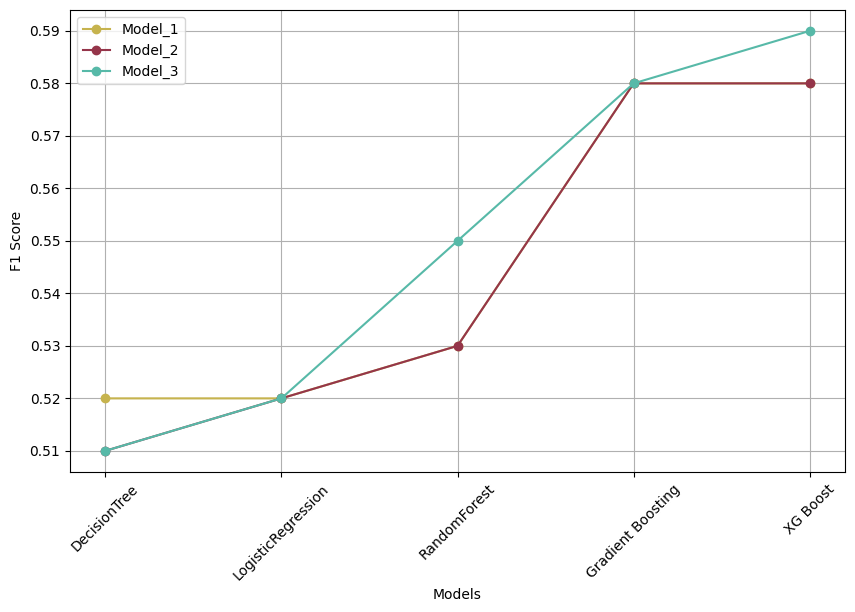

In [66]:
import matplotlib.pyplot as plt

# Create a line plot for a specific metric (e.g., F1 score) across models
plt.figure(figsize=(10, 6))
models_to_plot = ['Model_1', 'Model_2', 'Model_3']

for model in models_to_plot:
    plt.plot(combined_results.index, combined_results[model]['f1'], marker='o', label=model)

plt.xlabel('Models')
plt.ylabel('F1 Score')

plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()